In [2]:
import pandas as pd
loan=pd.read_csv('../cleaned_loan.csv')
pd.set_option('display.max_columns', None)

In [3]:
X=loan.drop(columns=['loan_status','loan_status_grouped','emp_title','title','issue_d', 'grade', 'annual_inc'])
y=loan['loan_status_grouped']

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

def sub_grades_encoding(x):
    grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
    number_mapping = {'1': 0.8, '2': 0.6, '3': 0.4, '4': 0.2, '5': 0.0}
    
    val = grade_mapping.get(x[0], 0) + number_mapping.get(x[1], 0)
    return val

X['sub_grade']= X['sub_grade'].apply(sub_grades_encoding)

In [5]:
#Separate numerical and non-numerical columns
ordinal_columns = ['emp_length']
categorical_columns = ['home_ownership', 'term', 'purpose']
numerical_columns = X.select_dtypes(include=['float64']).columns

# Apply Label Encoding to ordinal columns before splitting
le = LabelEncoder()
for col in ordinal_columns:
    X[col] = le.fit_transform(X[col])

# Apply OneHotEncoding to categorical columns before splitting
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Now perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Ensure the train and test sets have the same structure (dummies already handled)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Apply scaling to numerical columns
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=len(X_train.columns))
pca.fit(X_train)

PCA(n_components=37)

In [7]:
import numpy as np
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

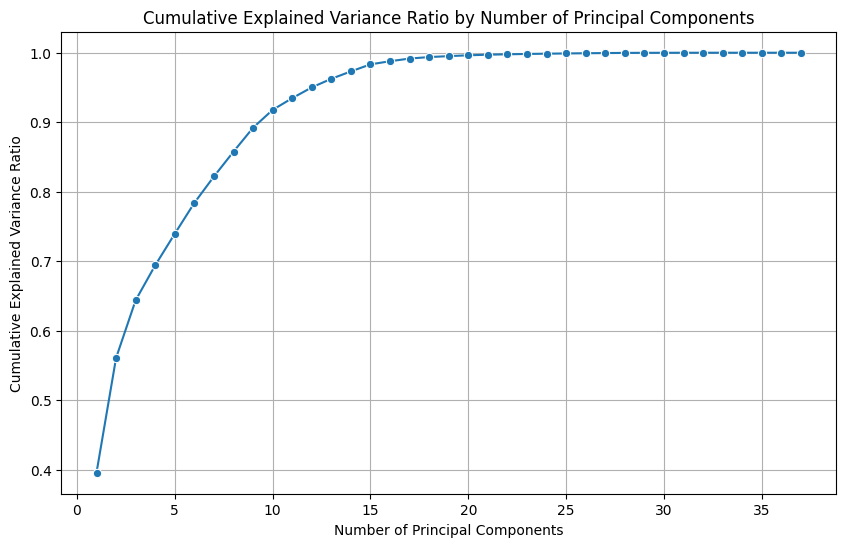

In [8]:
# Create a DataFrame for cumulative explained variance ratio
import matplotlib.pyplot as plt
import seaborn as sns

cvr = pd.DataFrame({

    'Number of Principal Components': range(1, len(cumulative_variance_ratio) + 1),

    'Cumulative Explained Variance Ratio': cumulative_variance_ratio

})


# Set up the figure

plt.figure(figsize=(10, 6))


# Create the line plot using Seaborn

sns.lineplot(data=cvr,

             x='Number of Principal Components',

             y='Cumulative Explained Variance Ratio',

             marker='o')  # Adding markers for clarity

# Add title and labels

plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')

plt.xlabel('Number of Principal Components')

plt.ylabel('Cumulative Explained Variance Ratio')

# Add grid lines for better readability

plt.grid(True)

# Show the figure

plt.show()

In [9]:
pca = PCA(n_components=10)

X_train_pca = pca.fit_transform(X_train)

X_test_pca = pca.transform(X_test)

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import metrics

model = keras.Sequential([
    layers.Dense(25, activation='relu', kernel_initializer='he_normal'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer with 10 classes and softmax activation

])

In [11]:
model.compile(optimizer='adam',

              loss='sparse_categorical_crossentropy', # for label encoding, transform it to one

              metrics=['accuracy'])

In [12]:
X_train_pca.shape[0]/64

3222.203125

In [13]:
# Train the model

model.fit(X_train_pca, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.7817 - loss: 0.5051 - val_accuracy: 0.7871 - val_loss: 0.4784
Epoch 2/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7901 - loss: 0.4692 - val_accuracy: 0.7914 - val_loss: 0.4700
Epoch 3/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7903 - loss: 0.4671 - val_accuracy: 0.7915 - val_loss: 0.4678
Epoch 4/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7900 - loss: 0.4673 - val_accuracy: 0.7897 - val_loss: 0.4678
Epoch 5/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7890 - loss: 0.4677 - val_accuracy: 0.7907 - val_loss: 0.4688
Epoch 6/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7907 - loss: 0.4656 - val_accuracy: 0.7912 - val_loss: 0.4679
Epoch 7/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7919 - loss: 0.4645 - val_accuracy: 0.7860 - val_loss: 0.4707
Epoch 8/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7902 - loss: 0

In [14]:
# Evaluate the model (with PCA)

loss, accuracy = model.evaluate(X_test_pca, y_test)
print('Test accuracy:', accuracy)

1612/1612 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7921 - loss: 0.4653
Test accuracy: 0.7894134521484375


1612/1612 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88     40328
         1.0       0.56      0.14      0.23     11228

    accuracy                           0.79     51556
   macro avg       0.68      0.56      0.55     51556
weighted avg       0.75      0.79      0.74     51556



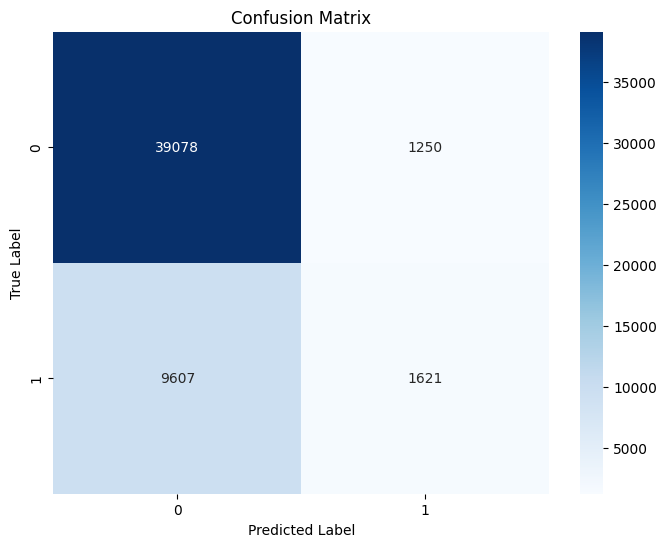

In [15]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test_pca)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Create classification report
print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
X_train.shape

(206221, 37)

In [20]:
X_train_pca.shape

(206221, 10)

In [22]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import metrics

model = keras.Sequential([
    layers.Dense(25, activation='relu', kernel_initializer='he_normal'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(37, activation='softmax')  # Output layer with 10 classes and softmax activation

])

In [24]:
model.compile(optimizer='adam',

              loss='sparse_categorical_crossentropy', # for label encoding, transform it to one

              metrics=['accuracy'])

In [25]:
# Train the model

model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9241 - loss: 0.2462 - val_accuracy: 0.9802 - val_loss: 0.0848
Epoch 2/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9802 - loss: 0.0784 - val_accuracy: 0.9759 - val_loss: 0.0856
Epoch 3/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9821 - loss: 0.0733 - val_accuracy: 0.9857 - val_loss: 0.0622
Epoch 4/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9835 - loss: 0.0696 - val_accuracy: 0.9867 - val_loss: 0.0596
Epoch 5/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9838 - loss: 0.0683 - val_accuracy: 0.9836 - val_loss: 0.0648
Epoch 6/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9848 - loss: 0.0640 - val_accuracy: 0.9857 - val_loss: 0.0604
Epoch 7/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9851 - loss: 0.0637 - val_accuracy: 0.9871 - val_loss: 0.0583
Epoch 8/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9857 - loss: 0

In [26]:
# Evaluate the model (without PCA)

loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

1612/1612 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9851 - loss: 0.0640
Test accuracy: 0.9853945374488831


1612/1612 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     40328
         1.0       0.99      0.94      0.97     11228

    accuracy                           0.99     51556
   macro avg       0.99      0.97      0.98     51556
weighted avg       0.99      0.99      0.99     51556



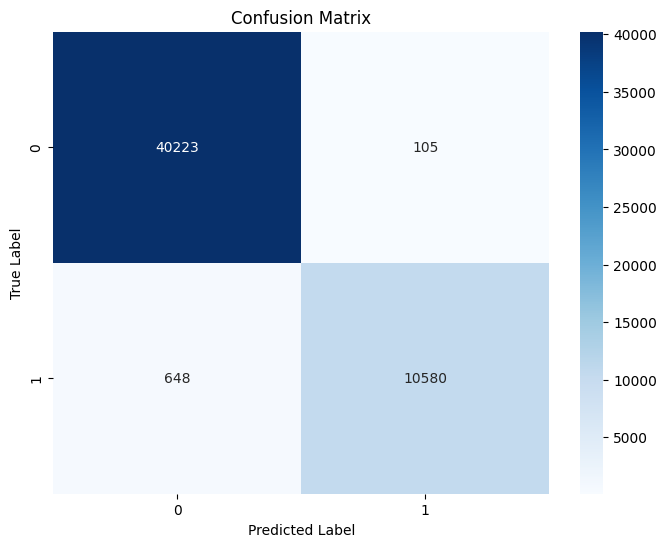

In [27]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Create classification report
print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [28]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=500,        # Number of boosting rounds
    learning_rate=0.1,       # Step size shrinkage to prevent overfitting
    max_depth=3,             # Maximum depth of a tree
    subsample=0.8,           # Subsample ratio of the training data
    colsample_bytree=0.8,    # Subsample ratio of features for each tree
    gamma=0,                 # Minimum loss reduction required to make a further partition
    reg_lambda=1,            # L2 regularization term
    objective='binary:logistic' # For multiclass classification (use 'binary:logistic' for binary)
)

In [29]:
# XG-boost (with PCA)
xgb.fit(X_train_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

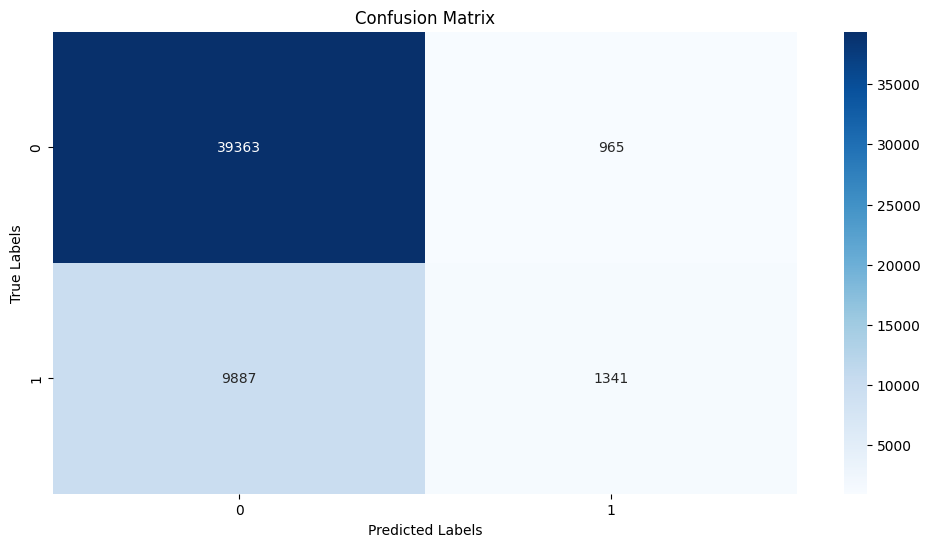

              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88     40328
         1.0       0.58      0.12      0.20     11228

    accuracy                           0.79     51556
   macro avg       0.69      0.55      0.54     51556
weighted avg       0.75      0.79      0.73     51556

Accuracy Test: 0.7895104352548685
F1 Score Test: 0.7306124807028831


In [31]:
y_pred_test_xgb = xgb.predict(X_test_pca)

cm = confusion_matrix(y_test, y_pred_test_xgb)

# Create a heatmap using Seaborn

plt.figure(figsize=(12, 6))  # Set the figure size

sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, xticklabels=['0', '1'], yticklabels=['0', '1'])

# Add titles and labels

plt.title('Confusion Matrix')

plt.xlabel('Predicted Labels')

plt.ylabel('True Labels')

plt.show()

print(classification_report(y_test, y_pred_test_xgb))

Accuracy_Test = accuracy_score(y_test, y_pred_test_xgb)

F1_Score_Test = f1_score(y_test, y_pred_test_xgb, average='weighted')

print(f"Accuracy Test: {Accuracy_Test}")

print(f"F1 Score Test: {F1_Score_Test}")

In [32]:
# XG-boost (without PCA)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

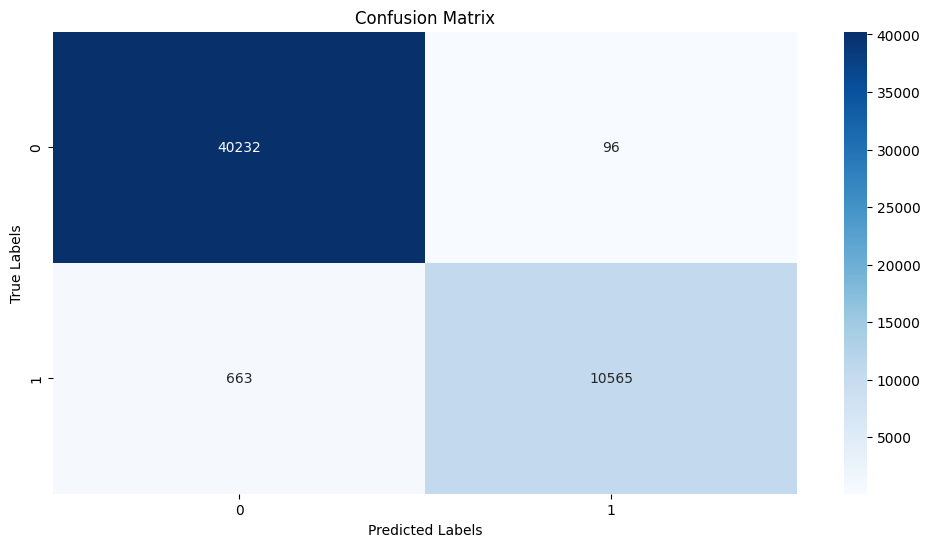

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     40328
         1.0       0.99      0.94      0.97     11228

    accuracy                           0.99     51556
   macro avg       0.99      0.97      0.98     51556
weighted avg       0.99      0.99      0.99     51556

Accuracy Test: 0.9852781441539297
F1 Score Test: 0.9851388559610644


In [33]:
y_pred_test_xgb = xgb.predict(X_test)

cm = confusion_matrix(y_test, y_pred_test_xgb)

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, xticklabels=['0', '1'], yticklabels=['0', '1'])

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(classification_report(y_test, y_pred_test_xgb))

Accuracy_Test = accuracy_score(y_test, y_pred_test_xgb)
F1_Score_Test = f1_score(y_test, y_pred_test_xgb, average='weighted')

print(f"Accuracy Test: {Accuracy_Test}")
print(f"F1 Score Test: {F1_Score_Test}")

In [34]:
# Random Forest Classifier (with PCA)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

rf_classifier = RandomForestClassifier(n_estimators=500,  max_depth=7, random_state=42)
rf_classifier.fit(X_train_pca, y_train)

RandomForestClassifier(max_depth=7, n_estimators=500, random_state=42)

In [35]:
y_pred_test = rf_classifier.predict(X_test_pca)

In [36]:
cm = confusion_matrix(y_test, y_pred_test)

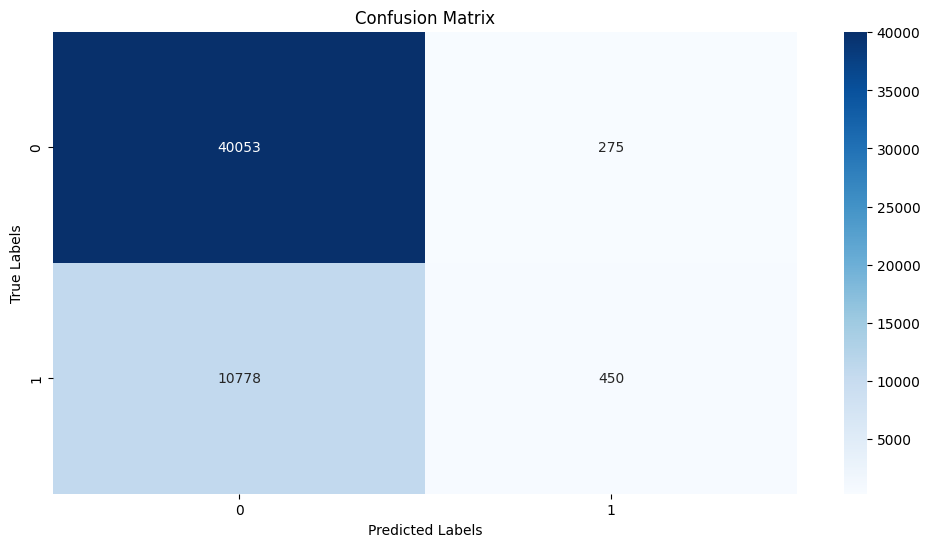

In [41]:
# Create a heatmap using Seaborn
plt.figure(figsize=(12, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, xticklabels=['0', '1'], yticklabels=['0', '1'])

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [42]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.79      0.99      0.88     40328
         1.0       0.62      0.04      0.08     11228

    accuracy                           0.79     51556
   macro avg       0.70      0.52      0.48     51556
weighted avg       0.75      0.79      0.70     51556



In [43]:
# Random forest classifier (without PCA)

rf_classifier = RandomForestClassifier(n_estimators=500,  max_depth=7, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=500, random_state=42)

In [45]:
y_pred_test = rf_classifier.predict(X_test)

In [46]:
cm = confusion_matrix(y_test, y_pred_test)

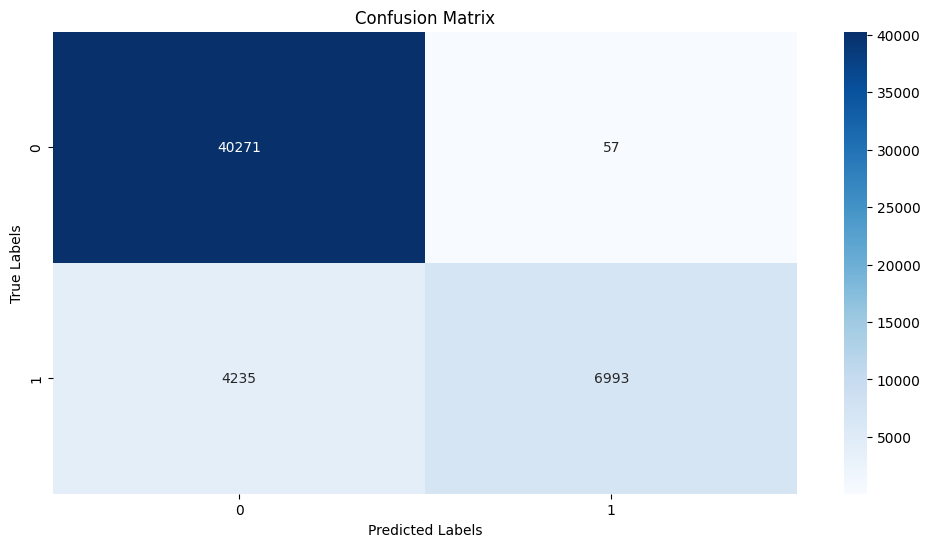

In [47]:
# Create a heatmap using Seaborn
plt.figure(figsize=(12, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, xticklabels=['0', '1'], yticklabels=['0', '1'])

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [48]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95     40328
         1.0       0.99      0.62      0.77     11228

    accuracy                           0.92     51556
   macro avg       0.95      0.81      0.86     51556
weighted avg       0.92      0.92      0.91     51556

